#### A `language model` is defined as a model that allows us to compute the joint probabilty of a sequence of words occuring in a language, i.e. $P(w_1, w_2, ..., w_n)$. Using the chain rule of probability, we can decompose this joint probabilty as follows:

$P(w_1, w_2, ..., w_n) = \prod_{k=1}^{n} P(w_k|w_{1:k-1})$

For long sequences, these conditional probabilities $P(w_k|w_{1:k-1})$ can be difficult to determine, so we use the `Markov assumption` according to which a word in a sequence only depends on a small part of it's history and not all of it's history, e.g. we can assume that any word in the sequence only depends on the last $N-1$ words preceding it so we have the following approximation: 

$P(w_k|w_{1:k-1}) \approx P(w_k|w_{k-N+1:k-1})$ 

The sequence of N-words $(w_{k-N+1}, w_{k-N+2}, ..., w_k)$ is a also called an `N-gram`. A language model where we assume a `context window` size no larger than N is called an N-gram language model. Specifically, for the case of a bigram model (N=2), we have the following:

$P(w_1, w_2, ..., w_n) = \prod_{k=1}^{n} P(w_k|w_{1:k-1}) \approx \prod_{k=1}^{n} P(w_k|w_{k-1})$.

To estimate the bigram conditional probabilities, we can use `Maximum Likelihood Estimation (MLE)` which involves counting occurances of unigrams from a training corpus.

$P(w_k|w_{k-1}) = \frac{C(w_{k-1}, w_k)}{\sum_{w \in V} C(w_{k-1}, w)} = \frac{C(w_k, w_{k-1})}{C(w_{k-1})}$

i.e. $P(w_k|w_{k-1})$ is just estimated as the relative proportion of times we observe the bigram $(w_{k-1}, w_k)$ out of all possible bigrams $(w_{k-1}, w)$ that have $w_{k-1}$ as the prefix. $C(w_{k-1}, w_k)$ denotes the observed count for the bigram $(w_{k-1}, w_k)$ and $w_{k-1}= \sum_{w \in V} C(w_{k-1}, w)$  is the count for the unigram $(w_{k-1})$ and $V$ denotes the vocabulary set.

Now let's implement a simple bigram language model trained using the collected works of Shakespeare as our training corpus. 

For our model, we will only consider words and neglect all punctuations and use lowercase folding.

In [53]:
import re

In [71]:
# get the text from file
with open('shakespeare.txt', 'r') as file:
    lines = file.readlines()

In [87]:
# remove all punctuations (except for apostrophe) and escape characters from the lines, lowercase all characters
sentences_clean = []
for line in lines:
    cleaned = re.sub(r"[^\w\s']",'',line).strip().lower()
    if len(cleaned) > 0:
        sentences_clean.append(cleaned)

# tokenize the sentences (split on whitespaces) and add start and end sentence tokens
start_token = '<s>'        
end_token = '</s>'        
sentences_tokenized = [[start_token]+s.split()+[end_token] for s in sentences_clean]
print(f"Num sentences: {len(sentences_tokenized)}")

Num sentences: 32777


In [93]:
import random

# now we split the data into train and test sentences
num_sent = len(sentences_tokenized)
num_test = int(0.1 * num_sent)
test_idx = random.sample(range(num_sent), num_test)

sentences_train = []
sentences_test = []
for i in range(num_sent):
    if i not in test_idx:
        sentences_train.append(sentences_tokenized[i])
    else:
        sentences_test.append(sentences_tokenized[i])    

print(f"Number of training sentences: {len(sentences_train)}")        
print(f"Number of test sentences: {len(sentences_test)}")        

Number of training sentences: 29500
Number of test sentences: 3277


#### Now that we have our training corpus ready to go, lets implement the bigram model.

In [298]:
from collections import defaultdict, Counter

class bigram_LM():

    def __init__(self):
        self.bigram_counts = None
        self.unigram_counts = None
        self.vocab = None
        self.word2idx = None
        self.bigram_probs = None
        self.num_sentences = None

    def train(self, sentences):
        self.num_sentences = len(sentences)
        self.unigram_counts, self.bigram_counts = self.get_counts(sentences)
        self.vocab = list(self.unigram_counts.keys())
        self.word2idx = {word:i for i,word in enumerate(self.vocab)}
        self.bigram_probs = self.compute_probs()

    def get_counts(self, sentences):
        # collect unigram counts (exclude the start of sentence token, because we don't want to generate it)
        unigram_counts = Counter()
        for s in sentences:
            for word in s[1:]:
                unigram_counts[word] += 1        
        # collect bigram counts
        bigram_counts = Counter()
        for s in sentences:
            for bigram in zip(s[:-1], s[1:]):
                bigram_counts[bigram] += 1      

        return unigram_counts, bigram_counts
    
    def compute_probs(self):
        bigram_probs = Counter()
        for word1 in self.vocab:
            probs = []
            for word2 in self.vocab:
                # compute P(word2|word1)
                p = self.bg_prob(word1, word2)
                probs.append(p)
            bigram_probs[word1] = probs 
        return bigram_probs   

    def bg_prob(self, word1, word2):
        if word1 != '<s>':
            p = self.bigram_counts[(word1, word2)]/self.unigram_counts[word1] 
        else:
            p = self.bigram_counts[(word1, word2)]/self.num_sentences
        return p        

In [299]:
model = bigram_LM()
model.train(sentences_train)

In [155]:
# let's sample some words from the 500 most frequent unigrams
random.seed(123)
num_samples = 12
words = random.sample(model.unigram_counts.most_common(500), num_samples)
words = sorted([elem[0] for elem in words])
print(words)

['any', 'before', 'bloody', 'ever', 'high', 'him', 'his', 'joy', 'many', 'now', 'o', 'told']


#### Let's visualize some counts and bigram probabilities

In [137]:
import numpy as np
import matplotlib.pyplot as plt

In [156]:
bg_counts = np.zeros(shape=(num_samples,num_samples))
bg_probs = np.zeros(shape=(num_samples,num_samples))
for i,word1 in enumerate(words):
    for j,word2 in enumerate(words):
        bg_counts[i,j] = model.bigram_counts[(word1,word2)]
        bg_probs[i,j] = model.bg_prob(word1,word2)

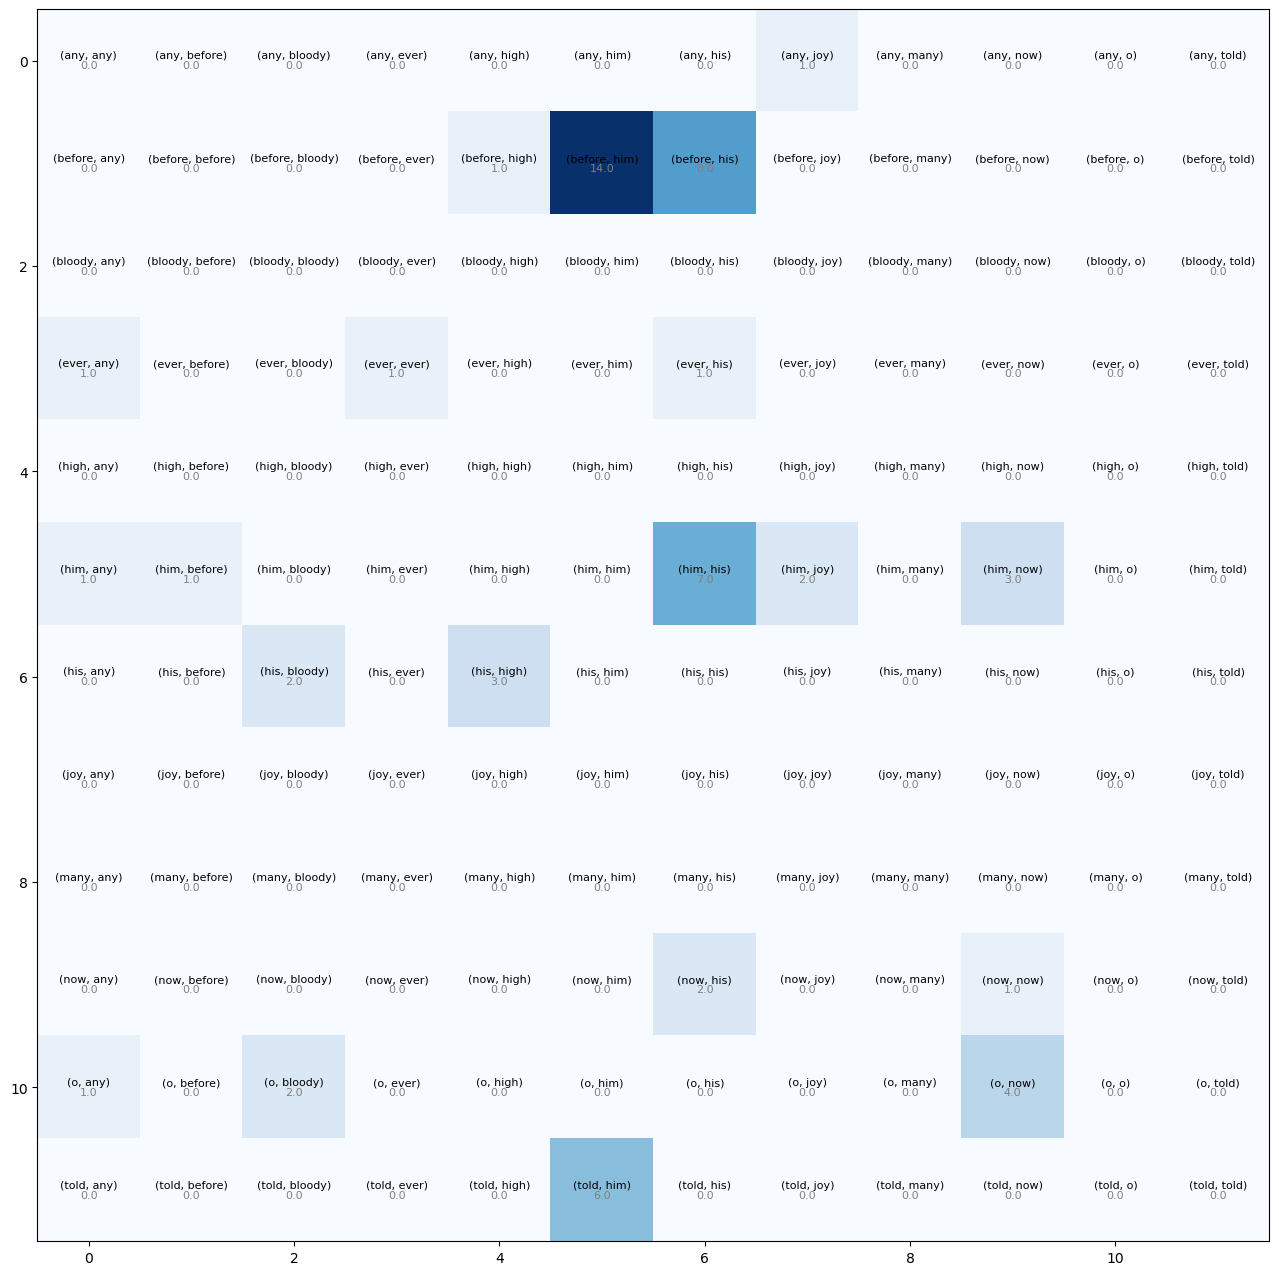

In [163]:
plt.figure(figsize=(16,16))
plt.imshow(bg_counts, cmap='Blues')
for i in range(num_samples):
    for j in range(num_samples):
        bgstr = f"({words[i]}, {words[j]})"
        plt.text(j,i, bgstr, ha='center', va='bottom', color='black', fontsize=8)
        plt.text(j,i, bg_counts[i,j].item(), ha='center', va='top', color='gray', fontsize=8)

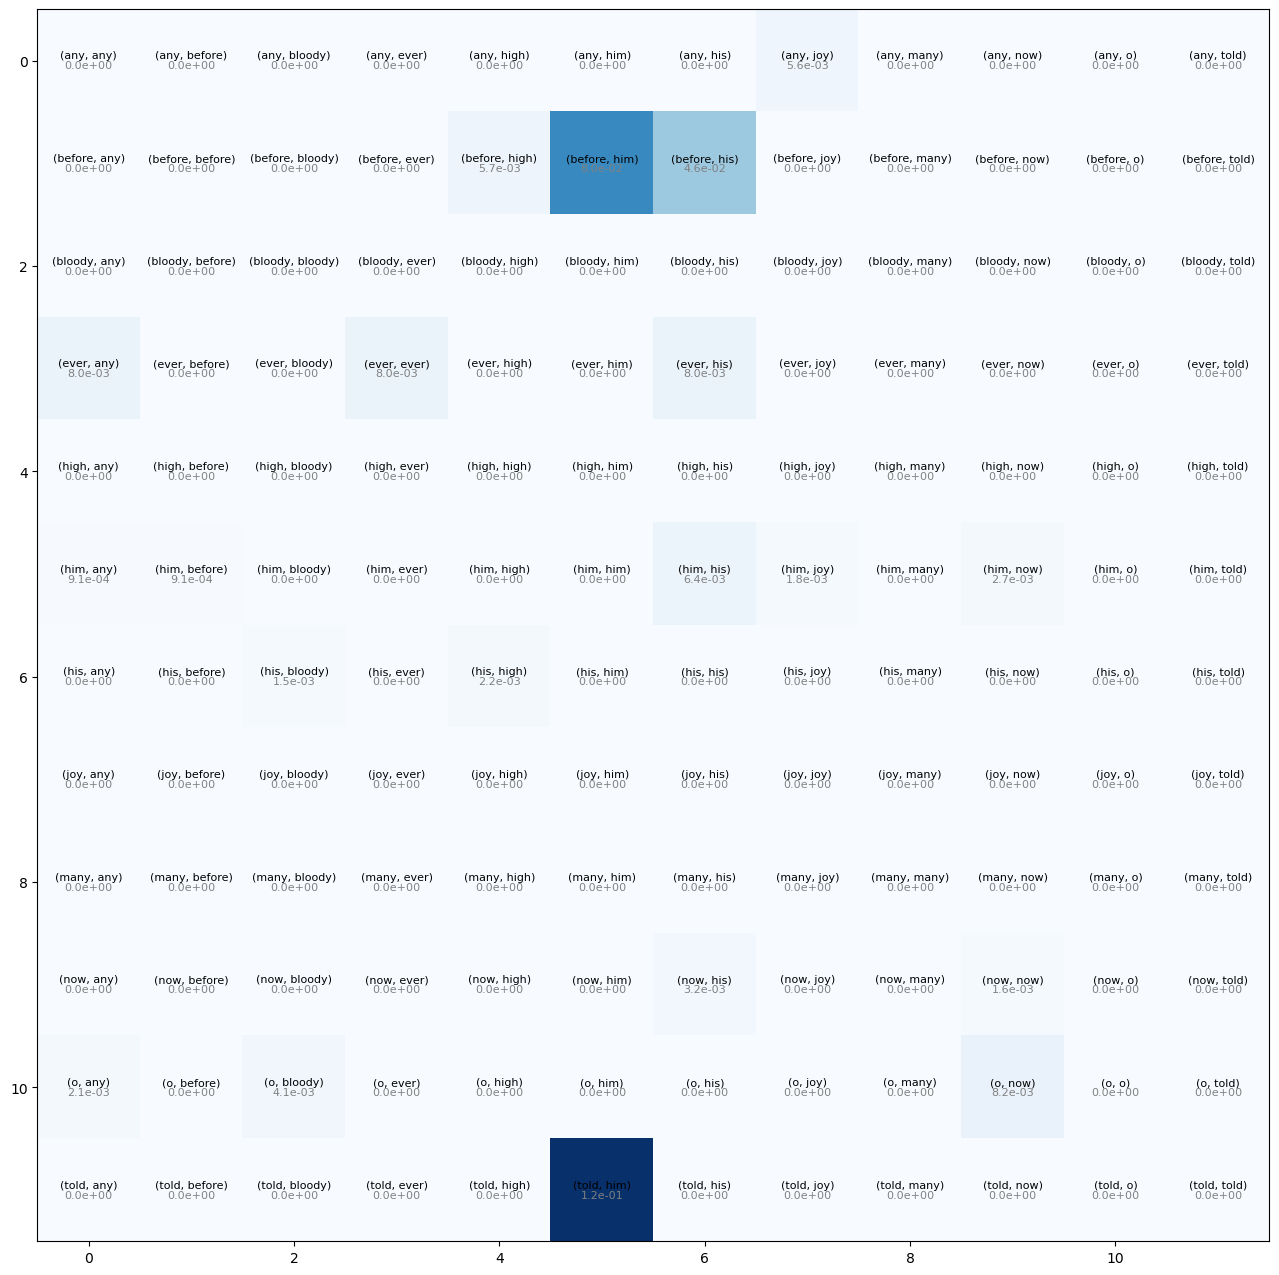

In [162]:
plt.figure(figsize=(16,16))
plt.imshow(bg_probs, cmap='Blues')
for i in range(num_samples):
    for j in range(num_samples):
        bgstr = f"({words[i]}, {words[j]})"
        plt.text(j,i, bgstr, ha='center', va='bottom', color='black', fontsize=8)
        plt.text(j,i, f"{bg_probs[i,j].item():.1e}", ha='center', va='top', color='gray', fontsize=8)

#### Note the sparsity in the bigram counts!

#### Now we can use the learned model to generate some text.

In [288]:
def generate_text(model, n=10):
    current_word = '<s>'
    probs = []
    for word in model.vocab:
        probs.append(model.bigram_counts[(current_word, word)]/model.num_sentences)
    current_word = random.choices(model.vocab, weights=probs, k=1)[0]

    words = [current_word]

    sentences = []
    i = 0
    for i in range(n):
        while True:
            # get probabilities of next word given current context, i.e P(w|w_current)
            probs = model.bigram_probs[current_word]
            # now sample from the vocabulry according to this distribution
            next_word = random.choices(model.vocab, weights=probs, k=1)[0]
            if next_word == '</s>':
                break
            words.append(next_word)
            current_word = next_word
        if len(words) > 0:    
            sentences.append(" ".join(words))
        i += 1
        words = []     
        
    return "\n".join(sentences)   


In [297]:
text = generate_text(model, n=100)
print(text)

farewell
thou shalt lose advantage of the flower with you
do you do and to prove this brightshining day
tomorrow
well
as dearly as sweet bianca
if thou shalt be counterpoised
at enmity
fair sun
sees
a while we found it shall i
lords have well met
a kingdom cannot be answer'd dost swallow dares ne'er drank sack
in farm our state when he could say even so up again
for than i will change no
little grave men throng to my prisoner to thy valour know that did myself in this we thought he took the prince
deserves
it not
whipt
out the air of camillo
wipe thou for sow'd


#### We will now evaluate the model by computing the perplexity:

$Perplexity(w_1,...,w_n) = (P(w_1,...,w_n))^{-\frac{1}{n}} = (\prod_{k=1}^{n} P(w_k|w_{k-1}))^{-\frac{1}{n}}$

#### To avoid numerical underflow, we will compute the log perplexity:

$Log Perplexity = -\frac{1}{n} \sum_{k=1}^{n} log(P(w_k|w_{k-1}))$


In [301]:
def compute_perplexity(model, test_sentences):
    sum_log_probs = 0.0
    n = 0
    for s in test_sentences:
        for w1,w2 in zip(s[:-1], s[1:]):
            sum_log_probs += np.log(model.bg_prob(w1, w2))
            n += 1
    sum_log_probs *= (-1/n) 
    perplexity = np.exp(sum_log_probs)
    return perplexity                    

In [302]:
pp = compute_perplexity(model, sentences_test)
print(f"Perplexity computed on test set: {pp}")

/tmp/ipykernel_200755/2944287313.py:6: RuntimeWarning: divide by zero encountered in log
  sum_log_probs += np.log(model.bg_prob(w1, w2))


ZeroDivisionError: division by zero

#### Note the division by zero error! This is happenining because we're seeing out-of-vocab words in the test set. Moreover, there will also be bigrams in the test set that have not occured in the training set which will also result in zero probabilities and cause the model to fail.